In [1]:
import numpy as np
import scipy
import random
import matplotlib.pyplot as plt

```% Created by Eugene M. Izhikevich, February 25, 2003

% Excitatory neurons Inhibitory neurons
Ne=800; Ni=200;
re=rand(Ne,1); ri=rand(Ni,1);

a=[0.02*ones(Ne,1); 0.02+0.08*ri];
b=[0.2*ones(Ne,1); 0.25-0.05*ri];
c=[-65+15*re.^2; -65*ones(Ni,1)];
d=[8-6*re.^2; 2*ones(Ni,1)];

S=[0.5*rand(Ne+Ni,Ne), -rand(Ne+Ni,Ni)];

v=-65*ones(Ne+Ni,1); % Initial values of v
u=b.*v; % Initial values of u

firings=[]; % spike timings

for t=1:1000 % simulation of 1000 ms

    I=[5*randn(Ne,1);2*randn(Ni,1)]; % thalamic input
    
    fired=find(v>=30); % indices of spikes
    firings=[firings; t+0*fired,fired];

    v(fired)=c(fired);
    u(fired)=u(fired)+d(fired);

    I=I+sum(S(:,fired),2);

    v=v+0.5*(0.04*v.^2+5*v+140-u+I); % step 0.5 ms
    v=v+0.5*(0.04*v.^2+5*v+140-u+I); % for numerical

    u=u+a.*(b.*v-u); % stability
end;


In [2]:

def simulate_izhikevich_network(dt=1.0, T_total=1000, Ne=800, Ni=200, seed=42):
    """
    Simulación generalizada de red de Izhikevich con paso de integración dt arbitrario
    
    Parámetros:
    dt: paso de integración en ms (default 1.0)
    T_total: tiempo total de simulación en ms
    Ne: número de neuronas excitatorias
    Ni: número de neuronas inhibitorias
    seed: semilla para reproducibilidad
    """
    
    np.random.seed(seed)
    
    # Inicialización (exactamente igual que el original)
    re = np.random.rand(Ne)
    ri = np.random.rand(Ni)
    
    # Parámetros del modelo (sin cambios)
    a = np.concatenate([0.02*np.ones(Ne), 0.02+0.08*ri])
    b = np.concatenate([0.2*np.ones(Ne), 0.25-0.05*ri])
    c = np.concatenate([-65+15*re**2, -65*np.ones(Ni)])
    d = np.concatenate([8-6*re**2, 2*np.ones(Ni)])
    
    k = 0.5
    S = np.concatenate([k * np.random.rand(Ne + Ni, Ne),
                       -2*k*np.random.rand(Ne + Ni, Ni)], axis=1)
    
    # Condiciones iniciales
    v = -65*np.ones(Ne+Ni)
    u = b*v
    
    # Arrays para almacenar resultados
    firings = []
    potentials = [v.copy()]
    I_thalamic_history = []
    I_synaptic_history = []
    I_total_history = []
    
    # Parámetros de simulación
    num_steps = int(T_total / dt)
    
    for step in range(num_steps):
        t = step * dt
        
        # Input talámico (escalado por sqrt(dt) para conservar varianza)
        I_thalamic = np.concatenate([
            5 * np.random.randn(Ne) / np.sqrt(dt),
            2 * np.random.randn(Ni) / np.sqrt(dt)
        ])
        
        # Corriente sináptica
        I_synaptic = np.zeros(Ne + Ni)
        
        # Detectar picos
        fired = np.where(v >= 30)[0]
        
        if len(fired) > 0:
            firings.extend([[t, neuron] for neuron in fired])
            v[fired] = c[fired]
            u[fired] = u[fired] + d[fired]
            I_synaptic = np.sum(S[:, fired], axis=1) / dt
        
        # Corriente total
        I_total = I_thalamic + I_synaptic
        
        # Integración con método de dos medios pasos (como el original)
        # Cada medio paso es dt/2, las ecuaciones se escalan por dt/2
        half_dt = dt / 2
        
        # Primer medio paso
        v = v + half_dt * (0.04 * v**2 + 5 * v + 140 - u + I_total)
        # Segundo medio paso  
        v = v + half_dt * (0.04 * v**2 + 5 * v + 140 - u + I_total)
        # Actualización de u (un paso completo dt)
        u = u + dt * a * (b * v - u)
        
        # Guardar historiales
        potentials.append(v.copy())
        I_thalamic_history.append(I_thalamic.copy())
        I_synaptic_history.append(I_synaptic.copy())
        I_total_history.append(I_total.copy())
    
    return {
        'firings': np.array(firings) if firings else np.array([]),
        'potentials': np.array(potentials),
        'I_thalamic_history': np.array(I_thalamic_history),
        'I_synaptic_history': np.array(I_synaptic_history),
        'I_total_history': np.array(I_total_history),
        'dt': dt
    }

def plot_results(results):
    """Función para graficar los resultados"""
    firings = results['firings']
    dt = results['dt']
    
    if len(firings) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(firings[:, 0], firings[:, 1], '.', markersize=0.8, color='black')
        plt.xlabel('Tiempo (ms)')
        plt.ylabel('Índice de neurona')
        plt.title(f'Red Izhikevich - Raster de picos (dt = {dt} ms)')
        plt.show()
        
        print(f"Total de picos: {len(firings)}")
    else:
        print("No se registraron picos")

=== Simulación con dt = 1.0 ms ===


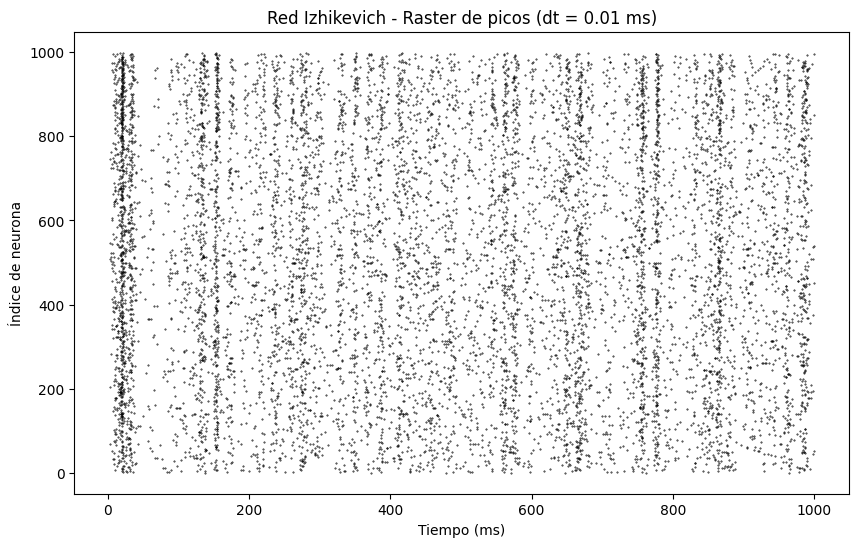

Total de picos: 9538


In [3]:
# Simulación con dt = 1.0 ms (original)
print("=== Simulación con dt = 1.0 ms ===")
results_1ms = simulate_izhikevich_network(dt=0.01, T_total=1000)
plot_results(results_1ms)

In [4]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

def simulate_izhikevich_clean(dt_val=1.0, T_total=1000, Ne=800, Ni=200, seed_val=42):
    """
    Implementación limpia con sinapsis puntuales y aplicación periódica
    """
    
    # Configurar
    np.random.seed(seed_val)
    seed(seed_val)
    defaultclock.dt = dt_val * ms
    
    # Parámetros (igual que original)
    re = np.random.rand(Ne)
    ri = np.random.rand(Ni)
    
    a_vals = np.concatenate([0.02*np.ones(Ne), 0.02+0.08*ri])
    b_vals = np.concatenate([0.2*np.ones(Ne), 0.25-0.05*ri])
    c_vals = np.concatenate([-65+15*re**2, -65*np.ones(Ni)])
    d_vals = np.concatenate([8-6*re**2, 2*np.ones(Ni)])
    
    # Matriz de conectividad
    k = 0.5
    S = np.concatenate([k * np.random.rand(Ne + Ni, Ne),
                       -2*k*np.random.rand(Ne + Ni, Ni)], axis=1)
    
    # Escalado para dt
    noise_scale = np.sqrt(dt_val)**(-1)
    syn_scale = 1.0
    
    # Pre-generar ruido talámico para toda la simulación
    time_steps = int(T_total / dt_val)
    noise_exc = np.random.randn(time_steps, Ne) * 5.0 * noise_scale
    noise_inh = np.random.randn(time_steps, Ni) * 2.0 * noise_scale
    
    # Combinar en un solo array
    noise_combined = np.concatenate([noise_exc, noise_inh], axis=1)
    stimulus_thalamic = TimedArray(noise_combined, dt=dt_val*ms)
    
    # Ecuaciones unificadas
    eqs = '''
    dv/dt = (0.04*v**2 + 5*v + 140 - u + I_syn + I_thalamic) / ms : 1
    du/dt = a*(b*v - u) / ms : 1
    I_syn : 1
    I_accum : 1
    I_thalamic = stimulus_thalamic(t, i) : 1
    a : 1 (constant)
    b : 1 (constant) 
    c : 1 (constant)
    d : 1 (constant)
    '''
    
    # Crear grupo
    G = NeuronGroup(Ne + Ni, eqs, threshold='v >= 30', 
                   reset='v = c; u += d', method='rk4')
    
    # Asignar parámetros
    G.a = a_vals
    G.b = b_vals
    G.c = c_vals
    G.d = d_vals
    G.v = -65
    G.u = G.b * G.v
    G.I_syn = 0
    G.I_accum = 0
    
    # Conexiones sinápticas con pesos escalados
    S_conn = Synapses(G, G, 'w : 1', on_pre='I_accum_post += w')
    S_conn.connect()  # Connect all-to-all
    
    # Set weights from matrix S (flattened and scaled)
    S_conn.w = (S.T * syn_scale).flatten()
    
    # Aplicar y resetear acumulado cada dt_val ms
    @network_operation(dt=1.0*ms)
    def apply_synapses():
        G.I_syn = G.I_accum
        G.I_accum = 0
    
    # Monitores
    spike_mon = SpikeMonitor(G)
    state_mon = StateMonitor(G, ['v', 'I_syn'], record=True)
    
    # Create explicit network
    net = Network(G, S_conn, apply_synapses, spike_mon, state_mon)
    
    # Ejecutar
    net.run(T_total * ms)
    
    return {
        'spike_times': np.array(spike_mon.t / ms),
        'spike_indices': np.array(spike_mon.i),
        'potentials': np.array(state_mon.v),
        'I_syn': np.array(state_mon.I_syn),
        'times': np.array(state_mon.t / ms),
        'dt': dt_val
    }

def plot_results_clean(results):
    """Graficar resultados"""
    plt.figure(figsize=(10, 6))
    plt.plot(results['spike_times'], results['spike_indices'], 
             '.', markersize=0.8, color='black')
    plt.xlabel('Tiempo (ms)')
    plt.ylabel('Índice de neurona')
    plt.title(f'Red Izhikevich Limpia - dt = {results["dt"]} ms')
    plt.show()
    print(f"Total de picos: {len(results['spike_times'])}")



/home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/setuptools/_distutils/_msvccompiler.py:12: UserWarning: _get_vc_env is private; find an alternative (pypa/distutils#340)
  warnings.warn(


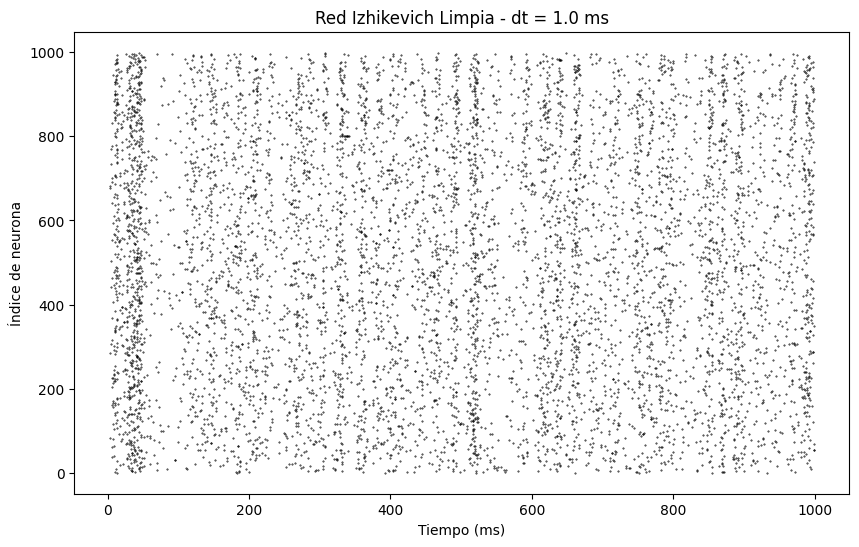

Total de picos: 7213


In [5]:
results_1 = simulate_izhikevich_clean(dt_val=1.0, T_total=1000)
plot_results_clean(results_1)

In [6]:
# Convertir listas a arrays
I_thalamic_matlab = np.array(I_thalamic_history)  # (1000, 1000)
I_synaptic_matlab = np.array(I_synaptic_history)  # (1000, 1000)
I_total_matlab = np.array(I_total_history)        # (1000, 1000)

# Separar excitatorias e inhibitorias
I_thal_exc_matlab = I_thalamic_matlab[:, :800]    # (1000, 800)
I_thal_inh_matlab = I_thalamic_matlab[:, 800:]    # (1000, 200)
I_syn_exc_matlab = I_synaptic_matlab[:, :800]     # (1000, 800)
I_syn_inh_matlab = I_synaptic_matlab[:, 800:]     # (1000, 200)
I_tot_exc_matlab = I_total_matlab[:, :800]        # (1000, 800)
I_tot_inh_matlab = I_total_matlab[:, 800:]        # (1000, 200)

# Estadísticas MATLAB
stats_matlab = {
    'thalamic_exc': {
        'mean_per_neuron': np.mean(I_thal_exc_matlab, axis=0),  # Media temporal por neurona
        'std_per_neuron': np.std(I_thal_exc_matlab, axis=0),    # Std temporal por neurona
        'mean_per_timestep': np.mean(I_thal_exc_matlab, axis=1), # Media poblacional por timestep
        'min_per_timestep': np.min(I_thal_exc_matlab, axis=1),
        'max_per_timestep': np.max(I_thal_exc_matlab, axis=1)
    },
    'synaptic_exc': {
        'mean_per_neuron': np.mean(I_syn_exc_matlab, axis=0),
        'std_per_neuron': np.std(I_syn_exc_matlab, axis=0),
        'mean_per_timestep': np.mean(I_syn_exc_matlab, axis=1),
        'min_per_timestep': np.min(I_syn_exc_matlab, axis=1),
        'max_per_timestep': np.max(I_syn_exc_matlab, axis=1)
    },
    'total_exc': {
        'mean_per_neuron': np.mean(I_tot_exc_matlab, axis=0),
        'std_per_neuron': np.std(I_tot_exc_matlab, axis=0),
        'mean_per_timestep': np.mean(I_tot_exc_matlab, axis=1),
        'min_per_timestep': np.min(I_tot_exc_matlab, axis=1),
        'max_per_timestep': np.max(I_tot_exc_matlab, axis=1)
    },
    'thalamic_inh': {
        'mean_per_neuron': np.mean(I_thal_inh_matlab, axis=0),  # Media temporal por neurona
        'std_per_neuron': np.std(I_thal_inh_matlab, axis=0),    # Std temporal por neurona
        'mean_per_timestep': np.mean(I_thal_inh_matlab, axis=1), # Media poblacional por timestep
        'min_per_timestep': np.min(I_thal_inh_matlab, axis=1),
        'max_per_timestep': np.max(I_thal_inh_matlab, axis=1)
    },
    'synaptic_inh': {
        'mean_per_neuron': np.mean(I_syn_inh_matlab, axis=0),
        'std_per_neuron': np.std(I_syn_inh_matlab, axis=0),
        'mean_per_timestep': np.mean(I_syn_inh_matlab, axis=1),
        'min_per_timestep': np.min(I_syn_inh_matlab, axis=1),
        'max_per_timestep': np.max(I_syn_inh_matlab, axis=1)
    },
    'total_inh': {
        'mean_per_neuron': np.mean(I_tot_inh_matlab, axis=0),
        'std_per_neuron': np.std(I_tot_inh_matlab, axis=0),
        'mean_per_timestep': np.mean(I_tot_inh_matlab, axis=1),
        'min_per_timestep': np.min(I_tot_inh_matlab, axis=1),
        'max_per_timestep': np.max(I_tot_inh_matlab, axis=1)
    }
}

NameError: name 'I_thalamic_history' is not defined

In [ ]:
# Comparar medias
print("=== INPUT TALÁMICO ===")
print(f"MATLAB exc - Media por neurona: {np.mean(stats_matlab['thalamic_exc']['mean_per_neuron']):.4f}")

print(f"MATLAB exc - Std por neurona: {np.mean(stats_matlab['thalamic_exc']['std_per_neuron']):.4f}")


print("\n=== INPUT SINÁPTICO ===")
print(f"MATLAB exc - Media: {np.mean(stats_matlab['synaptic_exc']['mean_per_neuron']):.4f}")

print(f"MATLAB exc - Std: {np.mean(stats_matlab['synaptic_exc']['std_per_neuron']):.4f}")


# Rangos de variación
print(f"MATLAB exc - Rango típico: [{np.mean(stats_matlab['synaptic_exc']['min_per_timestep']):.2f}, {np.mean(stats_matlab['synaptic_exc']['max_per_timestep']):.2f}]")


In [ ]:
plt.plot(range(0,1000), np.array(currents)[:,:800].mean(axis=1) , '--')

In [ ]:
# Python: después del cálculo sináptico
print("Input total neurona 0:", np.array(currents)[0,0])
print("Rango inputs en t_final:", np.min(np.array(currents)[0,:800]), np.max(np.array(currents)[0,:]))

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1000), np.array(potentials)[1:,10], '--', linewidth=0.3, color = 'black')
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)')
plt.title('Izhikevich Excitatory Neuron')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1000), np.array(potentials)[1:,-1], '--', linewidth=0.3, color = 'black')
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)')
plt.title('Izhikevich Inhibitory Neuron')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

plt.title('Distribución de Parámetros (Fig. 2)')
# 3. Distribución de parámetros c,d (como Fig. 2 del paper)
plt.subplot(2, 2, 1)
plt.hist(a[:800], alpha=0.4, color='red', bins= 10, label='Excitatorias a')
plt.hist(b[:800], alpha=0.4, color='blue', bins= 10,label='Excitatorias b')
plt.legend()
plt.subplot(2, 2, 2)
plt.hist(c[:800], alpha=0.4, color='green', bins= 5,label='Excitatorias c')
plt.hist(d[:800], alpha=0.4, color='orange', bins= 5,label='Excitatorias d')

plt.subplot(2, 2, 3)
plt.hist(a[800:], alpha=0.4, color='red', bins= 10,label='Inhibitorias a')
plt.hist(b[800:], alpha=0.4, color='blue', bins= 10,label='Inhibitorias b')
plt.subplot(2, 2, 4)
plt.hist(c[800:], alpha=0.4, color='green', bins= 2,label='Inhibitorias c')
plt.hist(d[800:], alpha=0.4, color='orange', bins= 2,label='Inhibitorias d')


plt.legend()

In [ ]:
plt.figure(figsize=(8, 6))
# 4. Histograma de frecuencias
plt.subplot(1,1,1)
freq_exc = []
freq_inh = []

for i in range(0,Ne):
    spike_count = sum(firings[:,1]==i)
    freq_exc.append(spike_count)

for i in range(Ne,Ne+Ni):
    spike_count = sum(firings[:,1]==i) 
    freq_inh.append(spike_count)

plt.hist(freq_exc, bins=30, alpha=0.7, density=True, label='Excitatorias')
plt.hist(freq_inh, bins=30, alpha=0.7, density=True, label='Inhibitorias')
plt.xlabel('Spikes en 1000ms')
plt.ylabel('Densidad')
plt.title('Distribución de Actividad')
plt.legend()

In [ ]:
# Análisis adicional para comparar con Brian2
# Actividad poblacional
bin_size = 5  # ms
time_bins = np.arange(0, 1000, bin_size)
activity = []
for t in time_bins:
    spikes_in_bin = np.sum((firings[:, 0] >= t) & (firings[:, 0] < t + bin_size))
    activity.append(spikes_in_bin)

plt.figure(figsize=(8, 6))

# Actividad de red
plt.subplot(1, 1, 1)
plt.plot(time_bins, activity, 'k-', linewidth=1)
plt.xlabel('Time (ms)')
plt.ylabel(f'Spikes/{bin_size}ms')
plt.title('Network Activity')

In [ ]:
# Análisis espectral
plt.subplot(1, 1, 1)
from scipy import signal
freqs, psd = signal.periodogram(activity, fs=1000/bin_size)
alpha_band = (freqs >= 8) & (freqs <= 12)
gamma_band = (freqs >= 30) & (freqs <= 50)

plt.plot(freqs, psd, 'k-', alpha=0.5)
plt.plot(freqs[alpha_band], psd[alpha_band], 'b-', linewidth=2, label='Alpha')
plt.plot(freqs[gamma_band], psd[gamma_band], 'r-', linewidth=2, label='Gamma')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.xlim(0, 100)
plt.legend()


In [ ]:
# Comparar distribuciones de pesos
print("Python S excitatorio:", np.mean(S[:, :800]), np.std(S[:, :800]))
print("Python S inhibitorio:", np.mean(S[:, 800:]), np.std(S[:, 800:]))

In [ ]:
# Python original - contar spikes por timestep
print("Python spikes/ms:", np.mean(firings[:,0]), np.max(firings[:,0]))
